# Week 11 Practice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

## Historical Volatility

The histotical volatility of Tesla, Inc.

In [2]:
TSLA = yf.download("TSLA", start="2022-11-25", end="2023-11-25")

[*********************100%%**********************]  1 of 1 completed


In [3]:
S = TSLA['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 235.45 .


In [4]:
log_return = np.log(TSLA['Adj Close'] / TSLA['Adj Close'].shift(1))
vol_h = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 58.49 %


## Volatility Smile

Volatility smiles are implied volatility patterns that arise in pricing financial options. It corresponds to finding one single parameter (implied volatility) that is needed to be modified for the Black–Scholes formula to fit market prices. 

### The Newton-Raphson Method to estimate impolied volatility

In [5]:
def newton_vol_call(S, K, T, C, r):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: risk free rate
    #sigma: volatility of underlying asset
   
    MAX_ITERATIONS = 1000
    tolerance = 0.000001
    
    sigma = 0.25
    
    for i in range(0, MAX_ITERATIONS):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)

        diff = C - price

        if (abs(diff) < tolerance):
            return sigma
        else: 
            sigma = sigma + diff/vega
        
        # print(i,sigma,diff)
        
    return sigma

Download the Tesla option data.

In [6]:
TESLA = yf.Ticker("TSLA")
opt = TESLA.option_chain('2023-12-29')
opt.calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA231229C00040000,2023-11-15 14:44:20+00:00,40.0,201.53,0.0,0.0,0.0,0.0,NaN,4,0.000010,True,REGULAR,USD
1,TSLA231229C00100000,2023-11-20 15:31:14+00:00,100.0,134.00,0.0,0.0,0.0,0.0,1.0,2,0.000010,True,REGULAR,USD
2,TSLA231229C00115000,2023-11-24 15:10:28+00:00,115.0,120.53,0.0,0.0,0.0,0.0,5.0,5,0.000010,True,REGULAR,USD
3,TSLA231229C00120000,2023-11-15 18:17:20+00:00,120.0,121.30,0.0,0.0,0.0,0.0,NaN,4,0.000010,True,REGULAR,USD
4,TSLA231229C00125000,2023-11-14 16:44:50+00:00,125.0,112.00,0.0,0.0,0.0,0.0,NaN,2,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,TSLA231229C00415000,2023-11-15 16:17:55+00:00,415.0,0.14,0.0,0.0,0.0,0.0,NaN,20,0.500005,False,REGULAR,USD
62,TSLA231229C00420000,2023-11-22 18:11:12+00:00,420.0,0.06,0.0,0.0,0.0,0.0,1.0,49,0.500005,False,REGULAR,USD
63,TSLA231229C00425000,2023-11-24 15:16:43+00:00,425.0,0.05,0.0,0.0,0.0,0.0,1.0,16,0.500005,False,REGULAR,USD
64,TSLA231229C00435000,2023-11-22 18:33:55+00:00,435.0,0.04,0.0,0.0,0.0,0.0,10.0,61,0.500005,False,REGULAR,USD


In [7]:
impvol = newton_vol_call(S, 200, 4/52, float(opt.calls.lastPrice[opt.calls.strike == 200.00]), 0.0353)
print('The implied volatility is', round(impvol*100,2) , '% for the one-month call with strike $ 200.00' ) 

The implied volatility is 58.27 % for the one-month call with strike $ 200.00


### The implied volatility returned by Mibian

In [8]:
import mibian

In [9]:
c = mibian.BS([S, 200.00, 3.53, 28], callPrice = float(opt.calls.lastPrice[opt.calls.strike == 200.00]))
# All returned values for a call option of non-dividend paying stock)
c.impliedVolatility
# Getting the implied volatility among all returned values; 
# Mibian uses the 'Bisection method' to calculate the implied volatility.
print('The implied volatility is', round(c.impliedVolatility,2) , '% for the one-month call with strike $ 200.00' ) 

The implied volatility is 58.35 % for the one-month call with strike $ 200.00


In [10]:
impliedvol = np.zeros((len(opt.calls.strike),1))
for i in range(len(opt.calls.strike)):
    c = mibian.BS([S, opt.calls.strike[i], 3.53, 28], callPrice = opt.calls.lastPrice[i])
    impliedvol [i] = c.impliedVolatility

Text(0.5, 1.0, 'Volatility Smile/Skew')

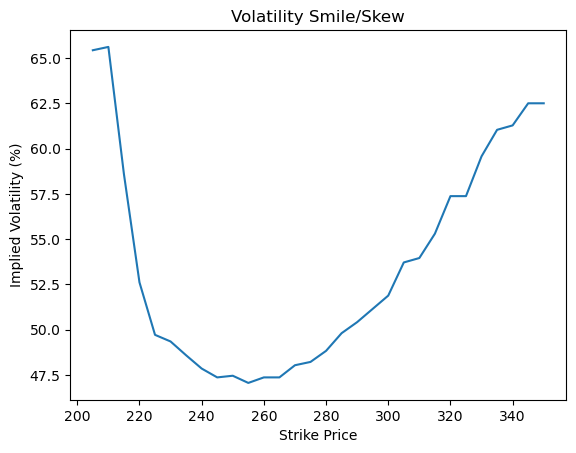

In [11]:
fig = plt.figure()
plt.plot(opt.calls.strike[20:50], impliedvol[20:50], '-')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.title('Volatility Smile/Skew')

## Term structure of volatility

Volatility term structures list the relationship between implied volatilities and time to expiration.

In [12]:
pip install -U arrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import arrow
T = ['2023-12-08','2023-12-15','2023-12-22','2023-12-29','2024-01-05',
     '2024-01-19','2024-02-16','2024-03-15','2024-04-19','2024-09-20','2025-01-17','2025-06-20','2025-09-19','2025-12-19','2026-01-16']

In [14]:
impliedvol_t = np.zeros((len(T),1))
now = arrow.get('2023-11-25')
days = np.zeros((len(T),1))
for j in range(len(T)):
    opt = TESLA.option_chain(T[j])
    temp = arrow.get(T[j])
    delta = temp - now
    days[j] = delta.days
    c = mibian.BS([S, 200, 3.53, days[j]], callPrice = float(opt.calls.lastPrice[opt.calls.strike==200]))
    impliedvol_t [j] = c.impliedVolatility

Text(0.5, 1.0, 'Term structure of volatility')

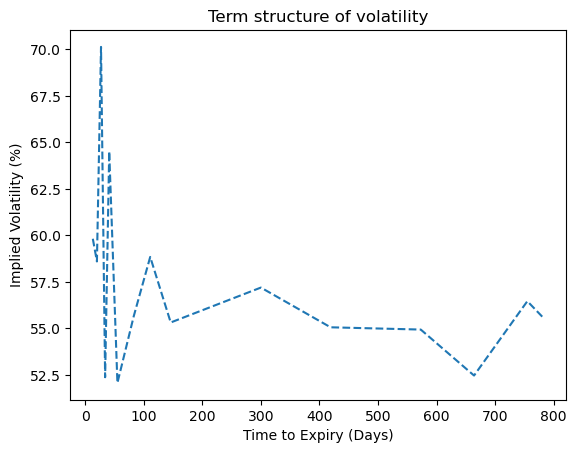

In [15]:
fig = plt.figure()
plt.plot(days, impliedvol_t, '--')
plt.xlabel('Time to Expiry (Days)')
plt.ylabel('Implied Volatility (%)')
plt.title('Term structure of volatility')

## Implied volatility surface

It is often useful to plot implied volatility as a function of both strike price and time to maturity. The result is a two-dimensional curved surface plotted in three dimensions whereby the current market implied volatility (z-axis) for all options on the underlying is plotted against the price (y-axis) and time to maturity (x-axis "DTM"). 

In [16]:
K = np.linspace(200.00,300.00,2)

In [17]:
impliedvol_s = np.zeros((len(K),len(days)))
for j in range(len(days)):
    for i in range(len(K)):
        opt = TESLA.option_chain(T[j])
        c = mibian.BS([S, K[i], 3.53, days[j]], callPrice = float(opt.calls.lastPrice[opt.calls.strike == K[i]]))
        impliedvol_s [i,j] = c.impliedVolatility

In [18]:
impliedvol_s

array([[59.81445312, 58.59375   , 70.12939453, 52.36816406, 64.51416016,
        52.06298828, 55.6640625 , 58.83789062, 55.31311035, 57.18994141,
        55.05371094, 54.93164062, 52.4597168 , 56.45751953, 55.54199219],
       [58.10546875, 53.22265625, 49.43847656, 46.99707031, 48.828125  ,
        45.95947266, 47.54638672, 46.58508301, 47.60742188, 49.12567139,
        50.61340332, 52.06298828, 50.07171631, 51.94091797, 51.57470703]])

Text(0.5, 1.0, 'Volatility Smile/Skew')

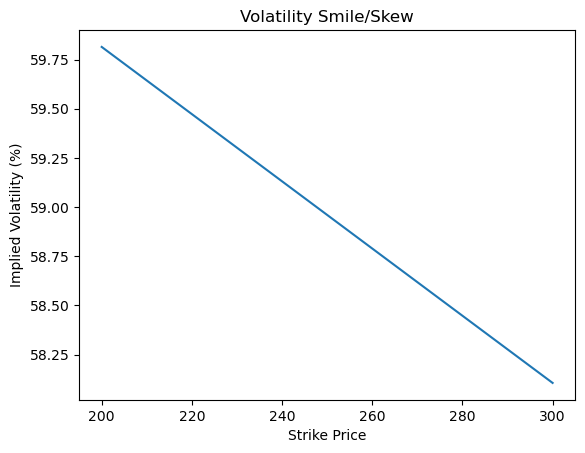

In [19]:
fig = plt.figure()
plt.plot(K, impliedvol_s[:,0], '-')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.title('Volatility Smile/Skew')

Text(0.5, 1.0, 'Term structure of volatility')

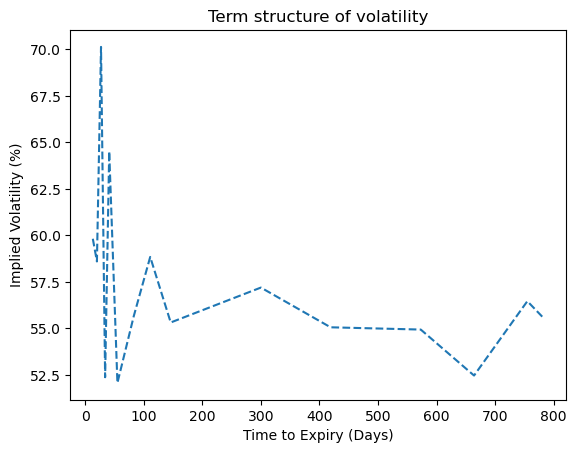

In [20]:
fig = plt.figure()
plt.plot(days, impliedvol_s[0,:], '--')
plt.xlabel('Time to Expiry (Days)')
plt.ylabel('Implied Volatility (%)')
plt.title('Term structure of volatility')

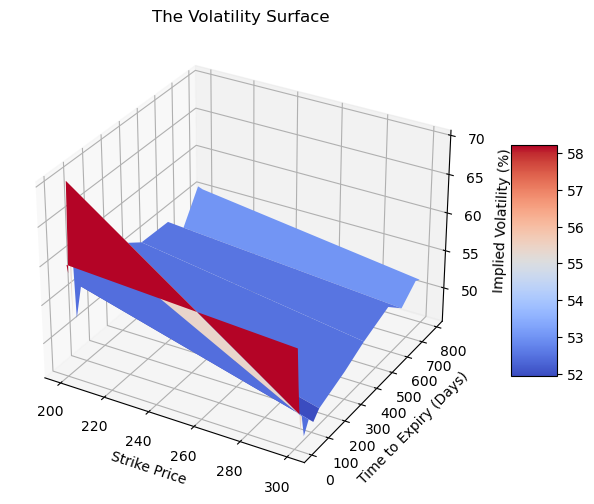

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
K, days = np.meshgrid(K, days)
surf = ax.plot_surface(K, days, impliedvol_s.T, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiry (Days)')
ax.set_zlabel('Implied Volatility (%)')
plt.title('The Volatility Surface')
fig.colorbar(surf, shrink=0.5, aspect=5);